In [1]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

import sys 
sys.path.append("..")

import hls4ml
import numpy as np
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt

from utils.config import print_dict

2023-09-25 02:04:35.617213: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jcampos/miniforge3/lib/:/home/jcampos/miniforge3/lib/
2023-09-25 02:04:35.617240: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
X_train_val = np.load('../data/new-raw-data/X_train.npy')
X_test = np.ascontiguousarray(np.load('../data/new-raw-data/X_test.npy'))
y_train_val = np.load('../data/new-raw-data/y_train.npy')
y_test = np.load('../data/new-raw-data/y_test.npy', allow_pickle=True)

# shift = 3
# X_train_val = np.right_shift(X_train_val.astype(np.int32), shift)
# X_test = np.right_shift(X_test.astype(np.int32), shift)

print(X_train_val.max())

6841.0


In [6]:
X_train_val.shape

(808000, 200)

In [7]:
co = {} 
_add_supported_quantized_objects(co)
model = load_model('/data/jcampos/ml-quantum-readout/training/src_keras/qkeras_v3_filter_pnq.h5', custom_objects=co, compile=False)

y_keras = model.predict(X_test)
print(f'Modelv3 (match filter) model acc: {accuracy_score(y_test, np.argmax(y_keras, axis=1))}')
print(model.summary()) 

2023-09-25 02:05:56.450951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jcampos/miniforge3/lib/:/home/jcampos/miniforge3/lib/
2023-09-25 02:05:56.451014: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-25 02:05:56.451070: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator3.fnal.gov): /proc/driver/nvidia/version does not exist
2023-09-25 02:05:56.451651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


6313/6313 [==============================] - 4s 656us/step
Modelv3 (match filter) model acc: 0.857019801980198
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 2)                 402       
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
Total params: 410
Trainable params: 406
Non-trainable params: 4
_________________________________________________________________
None


In [59]:
HLSConfig = {}
HLSConfig['Model'] = {}
HLSConfig['Model']['Precision'] = 'ap_fixed<16,6>'
HLSConfig['Model']['ReuseFactor'] = 1

HLSConfig['LayerName'] = {}
for layer in ['fc1_input', 'fc1', 'fc1_linear', 'batch_normalization']:
    HLSConfig['LayerName'][layer] = {}
    HLSConfig['LayerName'][layer]['Precision'] = {}
    HLSConfig['LayerName'][layer]['Trace'] = True

# Input
HLSConfig['LayerName']['fc1_input']['Precision'] = 'ap_fixed<14,14>'
# Fc
HLSConfig['LayerName']['fc1']['Precision']['result'] = 'ap_fixed<16,16>'
HLSConfig['LayerName']['fc1']['accum_t'] = 'ap_fixed<16,16>'
# Fc Linear
HLSConfig['LayerName']['fc1_linear']['Precision']['result'] = 'ap_fixed<16,16>'
# Batchnormalization
HLSConfig['LayerName']['batch_normalization']['Precision']['scale'] = 'ap_fixed<16,4>'
HLSConfig['LayerName']['batch_normalization']['Precision']['bias'] = 'ap_fixed<16,4>'
HLSConfig['LayerName']['batch_normalization']['Precision']['result'] = 'ap_fixed<6,4>'

print_dict(HLSConfig)

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
LayerName
  fc1_input
    Precision:       ap_fixed<14,14>
    Trace:           True
  fc1
    Precision
      result:        ap_fixed<16,16>
    Trace:           True
    accum_t:         ap_fixed<16,16>
  fc1_linear
    Precision
      result:        ap_fixed<16,16>
    Trace:           True
  batch_normalization
    Precision
      scale:         ap_fixed<16,4>
      bias:          ap_fixed<16,4>
      result:        ap_fixed<6,4>
    Trace:           True


In [60]:
OutputDir = 'hls4ml_qkeras_v3_match_prj/'
XilinxPart = 'xczu49dr-ffvf1760-2-e'
IOType = 'io_parallel'
ClockPeriod = 3.225
HLSFig = OutputDir+'model.png'

hls_model = hls4ml.converters.convert_from_keras_model(
    model=model,
    hls_config=HLSConfig,
    output_dir=OutputDir,
    part=XilinxPart,
    io_type=IOType,
    clock_period=ClockPeriod,
)


Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 200]], output shape: [None, 200]
Layer name: fc1, layer type: QDense, input shapes: [[None, 200]], output shape: [None, 2]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model


In [61]:
print(f"Creating hls4ml project directory {OutputDir}")
hls_model.compile()

# visualize model
hls4ml.utils.plot_model(
    hls_model, show_shapes=True, show_precision=True, to_file=HLSFig
)

Creating hls4ml project directory hls4ml_qkeras_v3_match_prj/
Writing HLS project


Done


In [62]:
# Trace output 
y_hls = hls_model.predict(np.ascontiguousarray(X_test.astype(np.float32))) 
_, hls_trace = hls_model.trace(np.ascontiguousarray(X_test.astype(np.float32))) 

keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test.astype(np.float32)) 

Recompiling myproject with tracing
Writing HLS project


Done
Processing fc1 in Keras model...
6313/6313 [==============================] - 4s 561us/step
Processing batch_normalization in Keras model...
6313/6313 [==============================] - 4s 630us/step
Done taking outputs for Keras model.


In [63]:
print(f'Keras Acc: {accuracy_score(y_test, np.argmax(y_keras, axis=1))*100}%')
print(f'HLS Acc: {accuracy_score(y_test, np.argmax(y_hls, axis=1))*100}%')
print(f'CKA: {accuracy_score(np.argmax(y_keras, axis=1), np.argmax(y_hls, axis=1))*100}%')

Keras Acc: 85.7019801980198%
HLS Acc: 85.4430693069307%
CKA: 94.67772277227724%


In [64]:
print(f'HLS Keys: {hls_trace.keys()}')
print(f'Keras Keys: {keras_trace.keys()}')

HLS Keys: dict_keys(['fc1', 'batch_normalization'])
Keras Keys: dict_keys(['fc1', 'fc1_function', 'batch_normalization'])


fc1 		 18.70729
hls/keras min: -27050.0/-27032.25
hls/keras max: 24887.0/24907.5
batch_normalization 		 0.26578346
hls/keras min: -6.0/-7.010474681854248
hls/keras max: 5.75/6.472051620483398


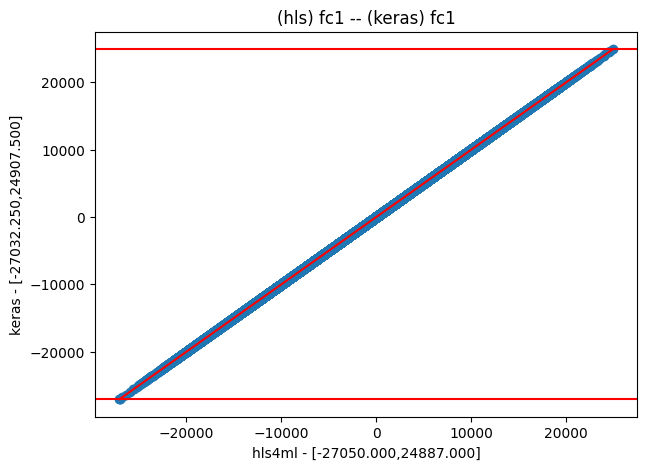

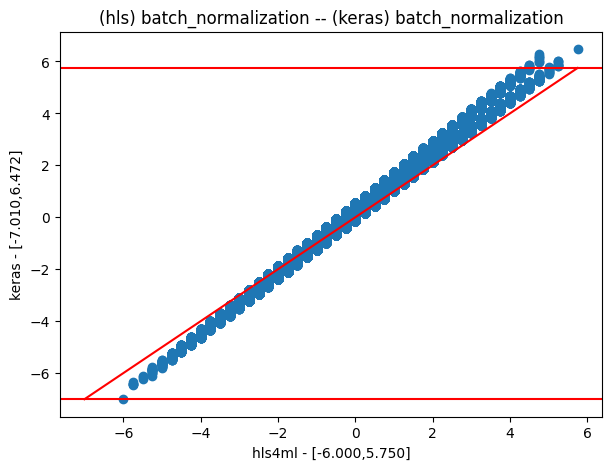

In [65]:
layers = ['fc1', 'batch_normalization']

for idx, layer in enumerate(layers):
    keras_layer, hls_layer = keras_trace[layer], hls_trace[layer]
    try:
        diff = np.average(np.abs(keras_layer - hls_layer ))
        print(f'{layer}', '\t\t', diff)
        
        plt.figure(figsize=(7, 5))

        plt.scatter(hls_layer.flatten(), keras_layer.flatten())
        min_x = min(keras_layer.min(), hls_layer.min())
        max_x = min(keras_layer.max(), hls_layer.max())

        onnx_min, onnx_max = keras_layer.flatten().min(), keras_layer.flatten().max()
        hls_min, hls_max = hls_layer.flatten().min(), hls_layer.flatten().max()
        
        print(f'hls/keras min: {hls_min}/{onnx_min}')
        print(f'hls/keras max: {hls_max}/{onnx_max}')
        
        plt.plot([min_x, max_x], [min_x, max_x], c='red')
        plt.axhline(min_x, c='red')
        plt.axhline(max_x, c='red')

        plt.title(f'(hls) {layer} -- (keras) {layer}')
        plt.xlabel(f'hls4ml - [{hls_min:.3f},{hls_max:.3f}]')
        plt.ylabel(f'keras - [{onnx_min:.3f},{onnx_max:.3f}]')
        plt.yscale('linear')
    except Exception as e:
        print(e)


In [70]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1.1 (64-bit)
  **** SW Build 2960000 on Wed Aug  5 22:57:21 MDT 2020
  **** IP Build 2956692 on Thu Aug  6 01:41:30 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /opt/local/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/local/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jcampos' on host 'correlator3.fnal.gov' (Linux_x86_64 version 3.10.0-1160.99.1.el7.x86_64) on Mon Sep 25 01:41:01 CDT 2023
INFO: [HLS 200-10] On os "Scientific Linux release 7.9 (Nitrogen)"
INFO: [HLS 200-10] In directory '/data/jcampos/ml-quantum-readout/notebooks/hls4ml_qkeras_v2_match_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/data/jcampos/ml-quantum-readout/notebooks/hls4ml_qkeras_v2_match_prj/myproject_prj'.
INFO: [HLS 200-10] Add

{'CSynthesisReport': {'EstimatedClockPeriod': '2.762',
  'BestLatency': '3',
  'WorstLatency': '3',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'DSP48E': '17',
  'FF': '45777',
  'LUT': '13576',
  'BRAM_18K': '0',
  'URAM': '0',
  'AvailableBRAM_18K': '2160',
  'AvailableDSP48E': '4272',
  'AvailableFF': '850560',
  'AvailableLUT': '425280',
  'AvailableURAM': '80'}}

In [29]:
gamma, beta, mean, var = model.layers[1].weights

In [30]:
epsilon = 0.001
scale = gamma / np.sqrt(var + epsilon)
print(scale)

tf.Tensor([9.151131e-06 8.555250e-06], shape=(2,), dtype=float32)


In [31]:
epsilon = 0.001
bias = -1 * mean / np.sqrt(var + epsilon) * gamma + beta 
bias

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 1.8962208, -1.66418  ], dtype=float32)>

In [32]:
keras_trace['fc1']

array([[-525980.,  597115.],
       [-471635.,  298742.],
       [-524014.,  548216.],
       ...,
       [-403696.,  268583.],
       [-524719.,  359208.],
       [-272128.,  326140.]], dtype=float32)

In [33]:
hls_trace['fc1']

array([[-525980.,  597115.],
       [-471635.,  298742.],
       [-524014.,  548216.],
       ...,
       [-403696.,  268583.],
       [-524719.,  359208.],
       [-272128.,  326140.]], dtype=float32)

In [34]:
keras_trace['batch_normalization']

array([[-2.9170914 ,  3.4442883 ],
       [-2.419773  ,  0.89163256],
       [-2.8991003 ,  3.0259452 ],
       ...,
       [-1.7980541 ,  0.6336148 ],
       [-2.9055514 ,  1.4089344 ],
       [-0.59405816,  1.1260293 ]], dtype=float32)

In [35]:
hls_trace['batch_normalization']

array([[ 1.8961182, -1.6641846],
       [ 1.8961182, -1.6641846],
       [ 1.8961182, -1.6641846],
       ...,
       [ 1.8961182, -1.6641846],
       [ 1.8961182, -1.6641846],
       [ 1.8961182, -1.6641846]], dtype=float32)

In [36]:
hls_trace['batch_normalization'].shape

(101000, 2)

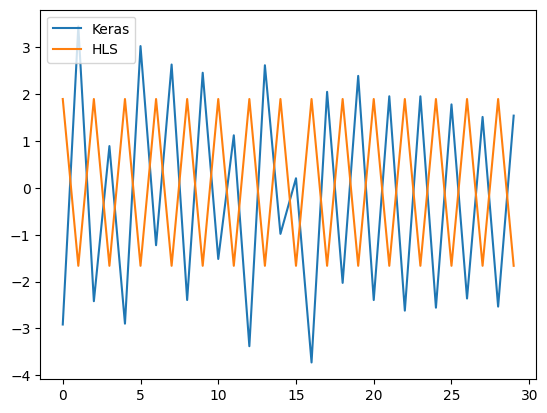

In [37]:
plt.figure()
plt.plot(keras_trace['batch_normalization'].reshape(-1)[:30], label='Keras')
plt.plot(hls_trace['batch_normalization'].reshape(-1)[:30], label='HLS')
plt.legend(loc='upper left')


In [26]:
keras_trace['batch_normalization'].shape

(202000, 2)

In [16]:
import math 

math.log2(25000)

14.609640474436812